In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold
from scHPL import train, predict, update, learn, utils, evaluate
import anndata

## Data loading

### Reading a csv file
During this tutorial, we will work with the simulated data. This dataset can be downloaded from the Zenodo repository (https://doi.org/10.5281/zenodo.4557712)

For scHPL, the input format of the simulated data is a csv file, but easiest is to work with AnnData objects when using scHPL. Here, we will first show, how to load the data and convert it to an AnnData object. 

In [2]:
data = pd.read_csv('Simulated_data.csv', index_col = 0)
data = data.T

labels = pd.read_csv('Simulated_labels.csv')
labels.columns=['labels']

In [3]:
row = dict(obs_names=data.index.astype(str))
col = dict(var_names=data.columns.astype(str))

adata = anndata.AnnData(data.values, row, col)

adata.obs = labels

Variable names are not unique. To make them unique, call `.var_names_make_unique`.


## scHPL without progressive learning

Here, we explain how to train a classifier without progressive learning, which can be used when the hierarchy is known beforehand.

First we split the dataset into a training and test set

In [4]:
x_train, x_test, y_train, y_test = train_test_split(adata.X, adata.obs['labels'], test_size=0.2, random_state=42)

### Creating a tree

We create a tree using the utils.create_tree() function. This function creates a tree based on the newick format.

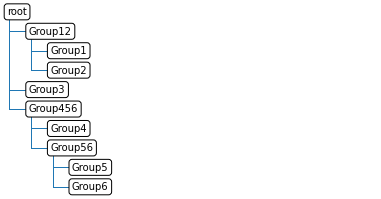

In [5]:
tree1 = utils.create_tree('((Group1, Group2)Group12, Group3,(Group4, (Group5, Group6)Group56)Group456)root')
utils.print_tree(tree1)

### Training the tree

Next, we train this tree. This function requires three inputs: the **data** matrix (cells x genes), **labels**, and the **tree**. Furtermore, there are some optional arguments:

- **classifier**: this can be either **svm_occ** for the one_class svm, **svm** for the linear SVM, or **knn** for the kNearestNeighbor classier (default=kNN). We recommend to use the kNN when you apply scHPL to a latent space of a low number of dimensions (e.g. 10)
- **dimred**: whether to apply dimensionality reduction to select features (default = False).<br>
For the one-class SVM, this is recommended.<br>
For the linear SVM, it is recommended to turn off and rely on the built-in L2-regularization.<br>
We recommend to use the kNN only when applying scHPL on a low number of dimensions (e.g. a latent space of 10), so extra dimensionality is not needed in that case and we recommend to turn this off.
- **useRE**: whether cells are rejected based on the reconstruction error (default = True).
- **FN**: percentage of false negatives allowed when using the reconstruction error (default = 0.5).

In [6]:
tree1 = train.train_tree(x_train, y_train, tree1, classifier = 'svm_occ', dimred = True, useRE = True, FN = 0.5)

## scHPL with progressive learning

scHPL can be used to learn a hierarchy of cell populations by combining the annotations of different datasets. scHPL, however, is not robust to batch effects between the datasets. We recommend to align the datasets before using scHPL

### Preprocessing the simulated data

We will again split the data in a train and test dataset. We will split the training dataset again in 3 batches to simulate different datasets. To simulate the effect of different resolutions in these batches, we have to relabel some of the populations (e.g. 'Group1' and 'Group2' are renamed as 'Group12')

### Unique labels for the training data

We merge the labels and batch names to ensure that every training batch has unique cell type labels. Because of this, we can better see the perfect matches in the dataset.

In [7]:
import copy as cp

sss = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 0)
sss.get_n_splits(x_train, y_train)

adata_progressive = anndata.AnnData(x_train)
adata_progressive.obs = pd.DataFrame(y_train)
adata_progressive.obs['batch'] = 0
count = 0

for trainindex, testindex in sss.split(x_train, y_train):    
    # Add the batch information
    adata_progressive.obs['batch'].iloc[testindex] = count
    count += 1

# In batch 1, we merge group1 and group2
xx = np.where((adata_progressive.obs['batch'] == 1) & 
              ((adata_progressive.obs['labels'] == 'Group1') | (adata_progressive.obs['labels'] == 'Group2')))[0]
adata_progressive.obs['labels'].values[xx] = 'Group12'

# In batch 1, we merge group4 and group5 and group6
xx = np.where((adata_progressive.obs['batch'] == 1) & 
              ((adata_progressive.obs['labels'] == 'Group4') | (adata_progressive.obs['labels'] == 'Group5') | (adata_progressive.obs['labels'] == 'Group6')))[0]
adata_progressive.obs['labels'].values[xx] = 'Group456'

# In batch 2, we merge group5 and group6
xx = np.where((adata_progressive.obs['batch'] == 2) & 
              ((adata_progressive.obs['labels'] == 'Group5') | (adata_progressive.obs['labels'] == 'Group6')))[0]
adata_progressive.obs['labels'].values[xx] = 'Group56'

adata_progressive.obs['labels-batch'] = np.char.add(np.char.add(np.array(adata_progressive.obs['labels'], dtype= str), '-'), 
                                                    np.array(adata_progressive.obs['batch'], dtype=str))

AnnData expects .obs.index to contain strings, but your first indices are: Int64Index([4607, 2233], dtype='int64'), …
C:\Users\lcmmichielsen\Anaconda3\lib\site-packages\pandas\core\indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


### Learning and training the tree

We learn the tree using the learn.learn_tree() function. 
There are different input parameters here:
- **data**: AnnData object containing the different datasets
- **batch_key**: Column name in adata.obs containing batch information 
- **batch_order**: List containing the order in which the batches should be added to the tree.
- **cell_type_key**: Column name in adata.obs containing the celltype labels.
- **tree** (default = None): Existing tree to update with the new datasets. If this is the first iteration, enter None.
- **retrain** (default = False): If 'True', the inputted tree will be retrained (needed if tree or datasets are changed after intial construction).
- **batch_added** (default = None): List that indicates which batches were used to build the existing tree.
- **classifier** (default = 'knn'): Classifier to use (either 'svm', 'svm_occ' or 'knn').
- **n_neighbors** (default = 50): Number of neighbors for the kNN classifier (only used when classifier='knn').
- **dimred** (default = False): If 'True' PCA is applied before training the classifier.
- **useRE** (default = True): If 'True', cells are also rejected based on the reconstruction error.
- **FN** (default = 0.5): Percentage of false negatives allowed when determining the threshold for the reconstruction error.
- **rej_threshold** (default = 0.5): If prediction probability lower that this threshold, a cell is rejected (only used when using kNN classifier).
- **match_threshold** (default = 0.25): Threshold to use when matching the labels.
- **attach_missing** (default = False): If 'True' missing nodes are attached to the root node.
- **print_conf** (default = False): Whether to print the confusion matrices during the matching step.

The function will output the tree and the missing cell populations. 

During the training process, the starting, intermediate and final hierarchies will be shown. The nodes that are added to the tree in the last iteration will be shown in bold.

Starting tree:


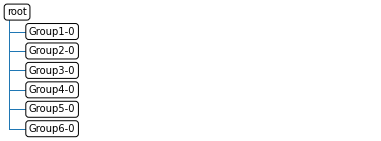


Adding dataset 1 to the tree

Updated tree:


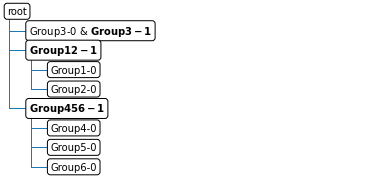


Adding dataset 2 to the tree

Updated tree:


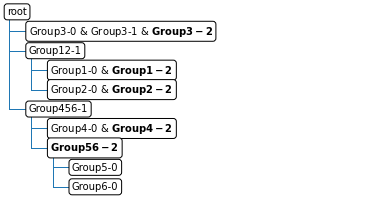

In [8]:
tree2, mp = learn.learn_tree(data = adata_progressive, 
                                        batch_key = 'batch',
                                        batch_order = [0,1,2],
                                        cell_type_key = 'labels-batch',
                                        classifier = 'svm_occ', 
                                        dimred = True)

### Predict labels

A trained tree (with or without progressive learning) can be used to predict the labels of another dataset

In [9]:
y_pred1 = predict.predict_labels(x_test, tree1) # tree constructed without progressive learning
y_pred2 = predict.predict_labels(x_test, tree2) # tree constructed with progressive

### Evaluate

Here, we evaluate the predictions based on the hierarchical F1-score and look at the confusion matrix.

For the progressive learning, we cannot look at the HF1-score since the names in the tree and not exactly the same as the names in the original dataset

Hierarchical F1-score without progressive learning:  0.96


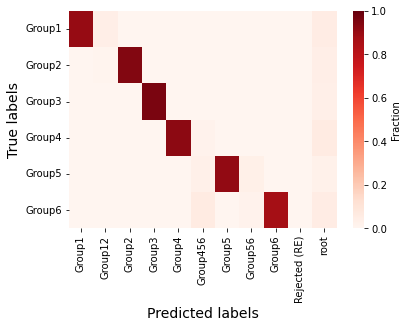

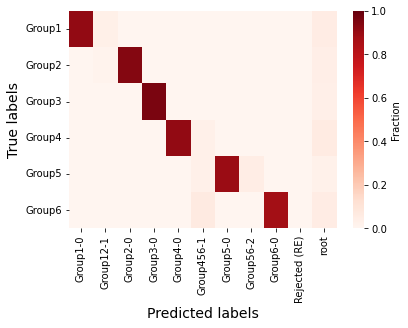

In [10]:
HF1_score1 = evaluate.hierarchical_F1(y_test.values, y_pred1, tree1)

print('Hierarchical F1-score without progressive learning: ', 
      np.round(HF1_score1,2))

confmatrix1 = evaluate.heatmap(y_test, y_pred1, shape=(6,4))
confmatrix2 = evaluate.heatmap(y_test, y_pred2, shape=(6,4))

## Other useful functions

Using the utils functions, nodes in the tree can be added, removed, or renamed. Note that after adding or removing a node, the tree has to be retrained.

Original tree:


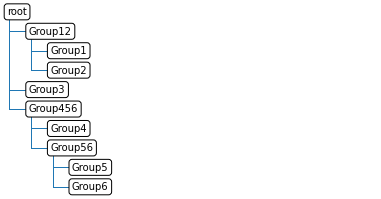

In [11]:
tree = utils.create_tree('((Group1, Group2)Group12, Group3,(Group4, (Group5, Group6)Group56)Group456)root')

print('Original tree:')
utils.print_tree(tree)


Tree after adding the new node:


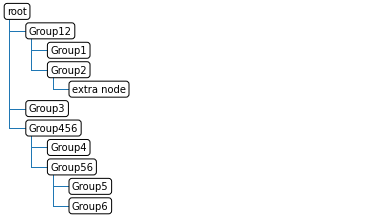

In [12]:
# Now we add a node to the tree
tree = utils.add_node(name = 'extra node', tree = tree, parent = 'Group2')
print('Tree after adding the new node:')
utils.print_tree(tree)

Tree after removing the node:


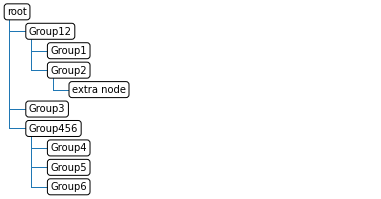

In [13]:
# Now we remove a node from the tree
# Children = False, indicates that the children should not be removed
tree = utils.remove_node(name = 'Group56', tree = tree, children = False)
print('Tree after removing the node:')
utils.print_tree(tree)

Tree after renaming the node:


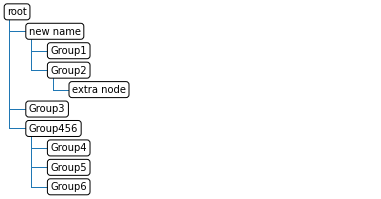

In [14]:
# We rename a node
tree = utils.rename_node(old_name = 'Group12', new_name = 'new name', tree = tree)
print('Tree after renaming the node:')
utils.print_tree(tree)